In this assignment we'll look at how to use the functionality of the solve_ivp funciton to extract physically meaningful results. Before we start, one of the things I want you to understand about learnign computational physics is that there is a trade-off between writing things from scratch to learn more, and using established tools to get results fast. In this assignemnet we're leaning more towards the latter. If you'd like to see how we might do the work in this assignment from scratch, send me a message and I can explain it to you.

Anyway, let's important some stuff and look at the documentation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

help(solve_ivp)

Help on function solve_ivp in module scipy.integrate._ivp.ivp:

solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
    Solve an initial value problem for a system of ODEs.
    
    This function numerically integrates a system of ordinary differential
    equations given an initial value::
    
        dy / dt = f(t, y)
        y(t0) = y0
    
    Here t is a 1-D independent variable (time), y(t) is an
    N-D vector-valued function (state), and an N-D
    vector-valued function f(t, y) determines the differential equations.
    The goal is to find y(t) approximately satisfying the differential
    equations, given an initial value y(t0)=y0.
    
    Some of the solvers support integration in the complex domain, but note
    that for stiff ODE solvers, the right-hand side must be
    complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
    To solve a problem in the complex domain, pass y0 with a co

Read the documentation about the "events" option. It lets us record the times at which certain events occur. Seems useful right? I'm going to use it to find the range of a projectile. First I'll write some code to simulat e the trajectory of a projectile. This time we will define our vector as $y(t) = \begin{bmatrix}  Y(t) \\  v_Y(t) \\  x(t) \\ v_x(t) \end{bmatrix}$ (please don't get confused. The convention for solve_ivp is that the vector is called $y$, so I've decided to label the height of the projectile as $Y$). The deriavative is then  $y'(t) = \begin{bmatrix}  v_Y(t) \\  a_Y(t) \\  v_x(t) \\ a_x(t) \end{bmatrix} = \begin{bmatrix}  v_Y(t) \\ -g \\  v_x(t) \\ 0 \end{bmatrix}$. Below I solve the equation and plot the trajectory. Have a look at the code, understand it, and then run it.

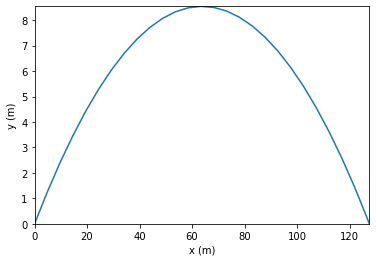

In [4]:
g = 9.8

tEval = np.linspace(0, 10, 100)

def rhsFun(t, y):
    # y =  [Y,   v_y, x,   v_x]
    # y' = [v_Y, a_Y, v_x, a_x]
    yPrime = [0, 0, 0, 0]
    
    yPrime[0] = y[1]
    yPrime[1] = -g
    yPrime[2] = y[3]
    yPrime[3] = 0    
    return yPrime

#Inital speed
v0 = 50
# Angle with respect to horizontal. I've chosen 15 degrees. Note
# we have to convert from degrees to radians.
alpha = 15 * (np.pi/180)

# Initial vector
Y0 = (0, v0*np.sin(alpha), 0, v0*np.cos(alpha))

sol1 = solve_ivp(rhsFun, (0, 10), Y0, t_eval=tEval)

# Note that x = sol1.y[2], and Y = sol1.y[0] (check how I defined the vector y)
plt.plot(sol1.y[2], sol1.y[0])
plt.ylim([0, max(sol1.y[0])])

# I get the theoretical range so that I can set axis limits
rangeTheoretical = (v0**2/g)*np.sin(2*alpha)
plt.xlim([0, rangeTheoretical])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

Now that this is working, I'll write an event function that helps us find the range. Go read the documentation for solve_ivp again, and you see that "events" should be a function that with the signature event(t, y), and it should return 0 at the event we want to find (if we want more than 1 type of event (eg range and max height) then we should pass a tuple of functions. It's very easy to write this function, because whent the projective has reached its range, its height is zero. Note that I assign the attribute terminal=True so that the simulation stops once the event is found. I plot the trajectory and also mark the x and y values that were detected by the event. I also compare the calculated range to the theoretical value. As you can see, everyhting is correct.

y events[0]: [[ 5.32907052e-15 -1.29417095e+01  1.27554752e+02  4.82962913e+01]]
y events[0][0]: [ 5.32907052e-15 -1.29417095e+01  1.27554752e+02  4.82962913e+01]
y events[0][0][0]: 5.329070518200751e-15
rangeSim: 127.55475234978039
Height when range reached: 5.329070518200751e-15


<ipython-input-11-5a424946397f>:30: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(sol1.y[2], sol1.y[0], rangeSim, heightWhenRangeReached, 'o', markerSize=20)


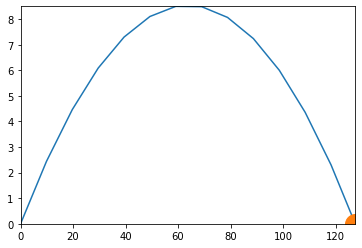

Range: theoretical: 127.55 m, calculated: 127.55 m


In [11]:
g = 9.8

tEval = np.linspace(0.00001, 10, 50)
def event1(t, y):
    return y[0]
#Note that we need to do this out here, rather than
#event1.terminal = True

v0 = 50
alpha = 15 * (np.pi/180)
Y0 = (0.001, v0*np.sin(alpha), 0, v0*np.cos(alpha))

# I've been a little sneaky here. If I started at height=0, then the very first moment would also be recorded as 
# an event (as well as the range). This isn't much of a problem - I could just pick the second event. But I thought
# it's a little more elegant to start witha  very small initial height
sol1 = solve_ivp(rhsFun, (0.00001, 10), Y0, t_eval=tEval, events=event1)

# Note indexing: first zero is because we want the first type of event. Secon zero is because we want the first instance
# If you're having trouble understanding this, run "print(sol1.y_events)" have a look at it.
print('y events[0]: ' + str(sol1.y_events[0]))
print('y events[0][0]: ' + str(sol1.y_events[0][0]))
print('y events[0][0][0]: ' + str(sol1.y_events[0][0][0]))
rangeSim = sol1.y_events[0][0][2]
print('rangeSim: ' + str(rangeSim))

# This is supposed to be zero, but let's pull it out just to be sure.
heightWhenRangeReached = sol1.y_events[0][0][0]
print('Height when range reached: ' + str(heightWhenRangeReached))

plt.plot(sol1.y[2], sol1.y[0], rangeSim, heightWhenRangeReached, 'o', markerSize=20)

plt.ylim([0, max(sol1.y[0])])
plt.xlim([0, sol1.y_events[0][0][2]])
# plt.xlabel
# plt.ylim([0, max(sol1.y[0])])
plt.show()

rangeTheoretical = (v0**2/g)*np.sin(2*alpha)

print("Range: theoretical: %.2f m, calculated: %.2f m" % (rangeTheoretical, rangeSim))

Below, I extend this code to calculate the range for a variety of initial angles, $\alpha$, and then plot the range against $\alpha$. We know for projectile motion that the range should be $R = \frac{v_0^2}{g} \sin(2\alpha)$, so I also plot this for comparison. As you can see, the maximum range occurs for $\alpha = 45^\circ$, which you may have already learned in your physics classes.

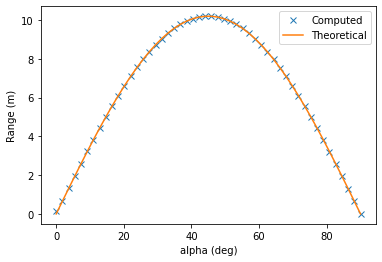

In [4]:
def getRange(v0, alpha):
    # Be careful, "range" is a (reserved) keyword
    
    alpha = alpha * (np.pi/180)
    Y0 = (0.001, v0*np.sin(alpha), 0, v0*np.cos(alpha))
    sol1 = solve_ivp(rhsFun, (0, 10), Y0, events=event1)
    rangeSim = sol1.y_events[0][0][2]
    return rangeSim

v0 = 10
alphas = np.linspace(0, 90, 50) 
ranges = np.zeros_like(alphas)

for i, alpha in enumerate(alphas):
    ranges[i] = getRange(v0, alpha)

rangesTheoretical = (v0**2/g)*np.sin(2*alphas*(np.pi/180))
plt.plot(alphas, ranges, 'x', alphas, rangesTheoretical)
plt.xlabel('alpha (deg)')
plt.ylabel('Range (m)')
plt.legend(('Computed', 'Theoretical'))
plt.show()

I'll do one more example. Remember in the first lesson I said that that a simple pendulum is governed by the DE $\theta''(t) = -\frac{g}{L} \sin{\theta}$. Let's start by solving that equation. I will use the vector $y(t) = \begin{bmatrix} \theta(t) \\ \theta'(t) \end{bmatrix}$, so that $y'(t)  = \begin{bmatrix} \theta'(t) \\ \theta''(t) \end{bmatrix} = \begin{bmatrix} \theta'(t) \\ -\frac{g}{L} \sin{\theta(t)} \end{bmatrix}$

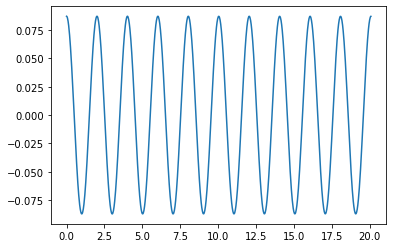

In [5]:
g = 9.8
L = 1.0

def rhsPendulum(t, y):
    # y = [theta, theta'']
    # y' = [theta', -(g/L) sin(theta)]
    yPrime = [0, 0]
    yPrime[0] = y[1]
    yPrime[1] = -(g/L)*np.sin(y[0])
    return yPrime

# Initial condition theta' = 0, theta = 5 deg
theta0 = 5*np.pi/180
y0 = [theta0, 0]

tF =  20*np.pi*np.sqrt(L/g)
tEval = np.linspace(0, tF, 1000)
sol = solve_ivp(rhsPendulum, (0, tF), y0, t_eval=tEval)

plt.plot(sol.t, sol.y[0])
plt.show()

Lovely. It's periodic with a constant amplitude, just as we expect. I'll now use an event to find the peaks values of $\theta$. This is really easy becuase when $\theta(t)$ is at a max/min value, $\theta'(t)$ must be zero. I find these and plot them below.

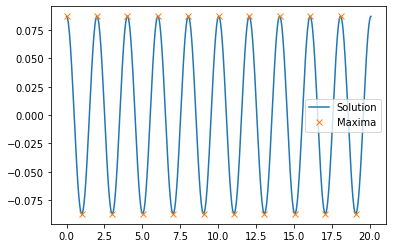

In [6]:
def getMaxMinTheta(t, y):
    return y[1]

# Note if we set getMaxMinTheta.direction = 1 then we will only capture when \theta'(t) changes from negative to positive. 
# That is, the minimum values. Try it. What about setting to -1 instead? If you're confused, read the documentation.
# Note that we have to do this outside the  function definition, otherwise the attribute will only be applied when the
# function is called (and because of function namespaces, solve_ivp will bever see it!)
# getMaxMinTheta.direction = 1

theta0 = 5*np.pi/180
y0 = [theta0, 0]
tF =  10*2*np.pi*np.sqrt(L/g)
tEval = np.linspace(0, tF, 1000)
sol = solve_ivp(rhsPendulum, (0, tF), y0, t_eval=tEval, events=getMaxMinTheta)

tsForMaxTheta = sol.t_events[0]
maxMinThetas = sol.y_events[0][:, 0]
plt.plot(sol.t, sol.y[0], tsForMaxTheta, maxMinThetas, 'x')
plt.legend(('Solution', 'Maxima'))
plt.show()

We can use these events in a clever way to compute the period. We know that the time between a max and a min must be half a period. One way to find the period is to just take the time between the first two events and double it. I could also take and average by taking the time difference between the first event and the last event, and realising that there must be (nEvents - 1) half-periods in this time interval. As you can see, both methods get an accurate result for the period.

In [7]:
#Simple
periodCompSimple = 2*(tsForMaxTheta[1] - tsForMaxTheta[0])

# Average 
numberOfHalfPeriods = len(tsForMaxTheta) - 1
numberOfPeriods = 0.5* numberOfHalfPeriods
tInterval = tsForMaxTheta[-1] - tsForMaxTheta[0]
#We know that tInterval = numberOfPeriods * (period Length)
#periodComp = (numberOfPeriods) / tInterval
periodComp = tInterval / numberOfPeriods

periodTheoretical = 2*np.pi*np.sqrt(L/g)
print("Period: computed (simple): %.2f, computed (average): %.2f theoretical: %.2f" % (periodCompSimple, periodComp, periodTheoretical))

Period: computed (simple): 2.01, computed (average): 2.01 theoretical: 2.01


## Tasks
1. By copying an modifying my code for the projectile, write an event that locates the time at which the projectile reaches maximum height. By simulating a range of initial angles ($\alpha$), plot a graph of max height against $\alpha$. The exact formula is $y_{max} = \frac{v_0^2}{2g} \sin^2(\alpha)$, so you can plot that to check your code.
2. Copy and modify the pendulum code to produce a plot of period against inital angle $\theta_0$. Is the period constant, or does it depend on the initial angle? Remember the formula you learned for the period assumes a small initial angle.
3. Take your simple harmonic motion code (with no damping) from the last assignment. Add an event that allows you to record the amplitude of oscillations (hint: you just need to find the max/min values of the displacement). Using a single simulation, produce a plot of amplitude as a function of time. Then add damping and see how the plot changes (make sure you keep it underdamped). Try changing the damping and observing how your plot changes. Does it make sense?

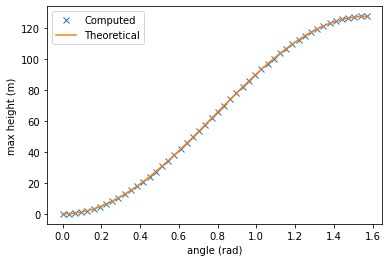

In [27]:
# Problem 1

g = 9.8
v0 = 50
tEval = np.linspace(0, 10, 100)
alphas = np.linspace(0, 90, 50)
alphas = alphas * (np.pi/180)
heights = []

def rhsFun(t, y):
    yPrime = [0, 0, 0, 0]
    
    yPrime[0] = y[1]
    yPrime[1] = -g
    yPrime[2] = y[3]
    yPrime[3] = 0    
    return yPrime

def maxHeightEvent(t, y):
    return y[1]/y[3]

for alpha in alphas:
    Y0 = (0, v0*np.sin(alpha), 0, v0*np.cos(alpha))
    sol1 = solve_ivp(rhsFun, (0, 10), Y0, t_eval=tEval, events=maxHeightEvent)
    
    heights.append(sol1.y_events[0][0, 0])

heightsTheoretical = (v0**2/(2*g))*(np.sin(alphas)**2)
    
plt.plot(alphas, heights, 'x')
plt.plot(alphas, heightsTheoretical)
plt.legend(('Computed', 'Theoretical'))
plt.xlabel('angle (rad)')
plt.ylabel('max height (m)')
plt.show()

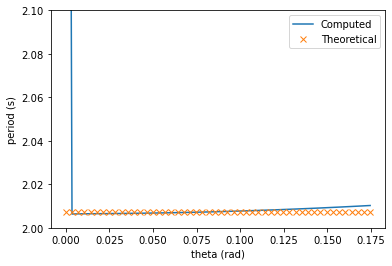

In [12]:
# Problem 2

g = 9.8
L = 1.0
tF =  20*np.pi*np.sqrt(L/g)
tEval = np.linspace(0, tF, 1000)

def rhsPendulum(t, y):
    yPrime = [0, 0]
    yPrime[0] = y[1]
    yPrime[1] = -(g/L)*np.sin(y[0])
    return yPrime

def extremaEvent(t, y):
    return y[1]


thetas = np.linspace(0, 10, 50)
thetas = thetas*np.pi/180
periods = []
periodsTheoretical = []

for i in thetas:
    sol = solve_ivp(rhsPendulum, (0, tF), [i, 0], t_eval=tEval, events=extremaEvent)
    n_halfperiods = len(sol.t_events[0]) - 1
    n_periods = 0.5*n_halfperiods
    t_periods = sol.t_events[0][-1] - sol.t_events[0][0]
    period = t_periods/n_periods
    periods.append(period)
    
    periodsTheoretical.append(2*np.pi*np.sqrt(L/g))

plt.plot(thetas, periods)
plt.plot(thetas, periodsTheoretical, 'x')
plt.ylim([2, 2.1])
plt.xlabel('theta (rad)')
plt.ylabel('period (s)')
plt.legend(('Computed', 'Theoretical'))
plt.show()

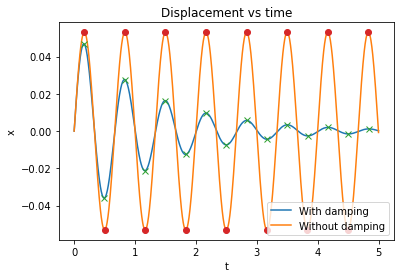

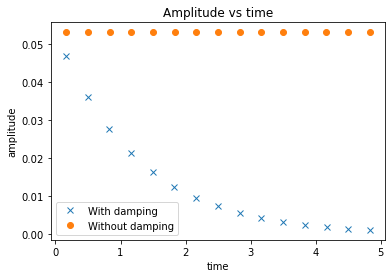

In [19]:
# Problem 3

omega = 3*np.pi
gamma = 0.5*np.pi
v0 = 0.5
tEndHarm = 5
tEvalHarm = np.linspace(0, tEndHarm, 1000)

def harmFuncNoDamp(t, y):
    deriv = [0, 0]
    deriv[0] = y[1]
    deriv[1] = - omega**2 * y[0]
    return deriv

def harmFuncDamp(t, y):
    deriv = [0, 0]
    deriv[0] = y[1]
    deriv[1] = - omega**2 * y[0] - gamma * y[1]
    return deriv

def extremaEvent(t, y):
    return y[1]

harmSolDamp = solve_ivp(harmFuncDamp, (0, tEndHarm), [0, v0], t_eval=tEvalHarm, events=extremaEvent)
harmSolNoDamp = solve_ivp(harmFuncNoDamp, (0, tEndHarm), [0, v0], t_eval=tEvalHarm, events=extremaEvent)

plt.plot(harmSolDamp.t, harmSolDamp.y[0], harmSolNoDamp.t, harmSolNoDamp.y[0])
plt.plot(harmSolDamp.t_events[0], harmSolDamp.y_events[0][:, 0], 'x', harmSolNoDamp.t_events[0], harmSolNoDamp.y_events[0][:, 0], 'o')
plt.xlabel('t')
plt.ylabel('x')
plt.legend(('With damping', 'Without damping'))
plt.title('Displacement vs time')
plt.show()


plt.plot(harmSolDamp.t_events[0], abs(harmSolDamp.y_events[0][:, 0]), 'x', harmSolNoDamp.t_events[0], abs(harmSolNoDamp.y_events[0][:, 0]), 'o')
plt.legend(('With damping', 'Without damping'))
plt.title('Amplitude vs time')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()